In [384]:
# Import required libraries
import pandas as pd
import hvplot.pandas
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import datetime
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

%matplotlib inline

In [385]:
# Load the environment variables from the .env file
# Call the load_dotenv function
load_dotenv()

True

In [386]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(
            alpaca_api_key,
            alpaca_secret_key,
            api_version = "v2")

In [387]:
timeframe = "1D"

today = str(datetime.datetime.today()).split()[0]

three_years_ago= str(datetime.datetime.today()- datetime.timedelta(days=1095)).split()[0]

start_date= pd.Timestamp(three_years_ago, tz="America/New_York").isoformat()

end_date= pd.Timestamp(today, tz="America/New_York").isoformat()
                       
limit_rows=1000
# Can allow user defined with IPY Widgets above 
tickers = ["DBA", "SPY"]

In [355]:
print("Preparing 3 years of historical data... Please wait")
alpaca_df= alpaca.get_barset(
               tickers,
               timeframe,
               limit= limit_rows,
               start = start_date,
               end = end_date
).df
display(alpaca_df.head())
display(alpaca_df.tail())

Preparing 3 years of historical data... Please wait


DBA                                     SPY  \
                            open   high      low  close   volume    open   
time                                                                       
2018-11-27 00:00:00-05:00  17.14  17.15  17.0600  17.10   618689  266.34   
2018-11-28 00:00:00-05:00  17.19  17.25  17.1502  17.25   331455  269.60   
2018-11-29 00:00:00-05:00  17.26  17.35  17.2400  17.27   556825  273.71   
2018-11-30 00:00:00-05:00  17.24  17.32  17.2100  17.29   390435  273.81   
2018-12-03 00:00:00-05:00  17.42  17.51  17.3300  17.36  1677463  280.28   

                                                                
                             high       low   close     volume  
time                                                            
2018-11-27 00:00:00-05:00  268.37  265.6600  268.34   65180166  
2018-11-28 00:00:00-05:00  275.10  268.3272  274.50  111668695  
2018-11-29 00:00:00-05:00  275.55  272.4300  273.93   69394238  
2018-11-30 00:00:00-05:00  279.11  273.4500  275.78   80116769  
2018-12-03 00:00:00-05:00  280.40  277.5050  279.25   86242190

DBA                                    SPY  \
                            open   high     low  close   volume    open   
time                                                                      
2021-11-18 00:00:00-05:00  20.15  20.23  19.985  20.03   957250  469.24   
2021-11-19 00:00:00-05:00  20.08  20.13  20.020  20.06   673169  469.61   
2021-11-22 00:00:00-05:00  20.03  20.18  20.030  20.15  1511501  470.81   
2021-11-23 00:00:00-05:00  20.15  20.31  20.110  20.31   984239  467.22   
2021-11-24 00:00:00-05:00  20.26  20.37  20.260  20.28   684345  466.06   

                                                              
                              high     low   close    volume  
time                                                          
2021-11-18 00:00:00-05:00  470.010  466.34  469.71  45100029  
2021-11-19 00:00:00-05:00  470.940  468.50  468.91  49009452  
2021-11-22 00:00:00-05:00  473.540  467.35  467.53  61497941  
2021-11-23 00:00:00-05:00  469.095  464.45  468.25  62851184  
2021-11-24 00:00:00-05:00  469.570  465.19  469.37  54274217

In [356]:
# Creating new DF that contains closing prices for DBA and SPY
closing_prices= pd.DataFrame()
closing_prices["DBA"]= alpaca_df["DBA"]["close"]
closing_prices["SPY"]= alpaca_df["SPY"]["close"]
closing_prices.index= closing_prices.index.date
closing_prices.head()

,DBA,SPY
2018-11-27,17.10,268.34
2018-11-28,17.25,274.50
2018-11-29,17.27,273.93
2018-11-30,17.29,275.78
2018-12-03,17.36,279.25


In [389]:
closing_prices.hvplot(rot=90, figsize=(15,7), title= "Closing prices of DBA and SPY")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [358]:
#Calculating daily returns
daily_returns= closing_prices.pct_change().dropna()
daily_returns.tail()

,DBA,SPY
2021-11-18,-0.002987,0.003418
2021-11-19,0.001498,-0.001703
2021-11-22,0.004487,-0.002943
2021-11-23,0.007940,0.001540
2021-11-24,-0.001477,0.002392


In [359]:
#Calculating "DBA" variance
dba_variance= daily_returns["DBA"].var()
dba_variance

6.885192724901288e-05

In [360]:
# Calculating "SPY" variance
spy_variance= daily_returns["SPY"].var()
spy_variance

0.0002038225920366035

In [361]:
# Calculating covariance between "DBA" and "SPY"
covariance= daily_returns["DBA"].cov(daily_returns["SPY"])
print(f"{covariance: .8f}")


 0.00003537


In [362]:
# Calculating beta for DBA
dba_beta= covariance/ spy_variance
dba_beta

0.1735559855742951

Based on the above metrics we can see that "DBA" fund which for the purpose of this analysis
we can treat as a proxy for the farmland has got positive variance with the overall market ("SPY"). That means that its prices tend to move in the same direction. However, the "DBA" beta value tells us that the change in the asset's return value will likely be less than that of the market. That's what makes investing in farmland in a great hedge against the risks of overall market.


# DBA stock price prediction using LSTM

In [363]:
alpaca_df.head()

DBA                                     SPY  \
                            open   high      low  close   volume    open   
time                                                                       
2018-11-27 00:00:00-05:00  17.14  17.15  17.0600  17.10   618689  266.34   
2018-11-28 00:00:00-05:00  17.19  17.25  17.1502  17.25   331455  269.60   
2018-11-29 00:00:00-05:00  17.26  17.35  17.2400  17.27   556825  273.71   
2018-11-30 00:00:00-05:00  17.24  17.32  17.2100  17.29   390435  273.81   
2018-12-03 00:00:00-05:00  17.42  17.51  17.3300  17.36  1677463  280.28   

                                                                
                             high       low   close     volume  
time                                                            
2018-11-27 00:00:00-05:00  268.37  265.6600  268.34   65180166  
2018-11-28 00:00:00-05:00  275.10  268.3272  274.50  111668695  
2018-11-29 00:00:00-05:00  275.55  272.4300  273.93   69394238  
2018-11-30 00:00:00-05:00  279.11  273.4500  275.78   80116769  
2018-12-03 00:00:00-05:00  280.40  277.5050  279.25   86242190

In [364]:
dba_df= alpaca_df["DBA"]
dba_df.index=dba_df.index.date
dba_df.head()

,open,high,low,close,volume
2018-11-27,17.14,17.15,17.0600,17.10,618689
2018-11-28,17.19,17.25,17.1502,17.25,331455
2018-11-29,17.26,17.35,17.2400,17.27,556825
2018-11-30,17.24,17.32,17.2100,17.29,390435
2018-12-03,17.42,17.51,17.3300,17.36,1677463


In [366]:
dba_df.shape

(755, 5)

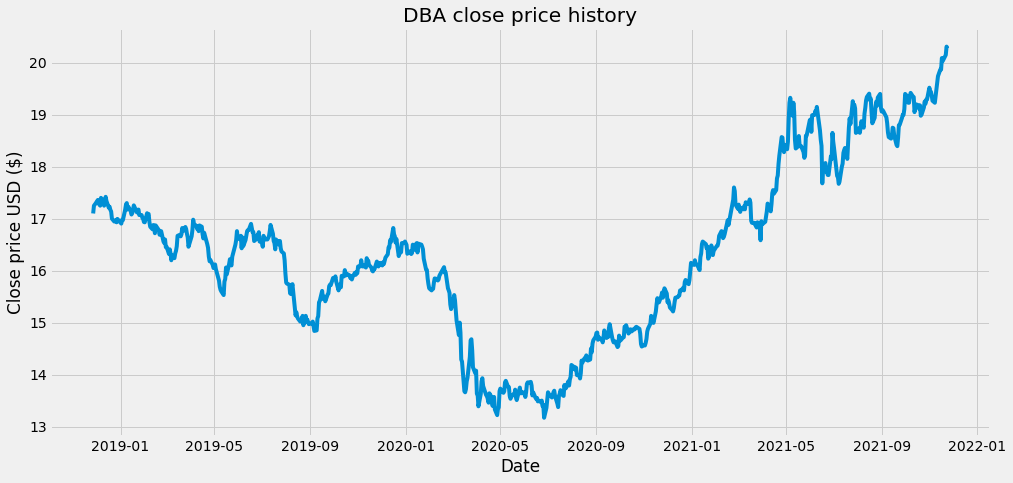

In [367]:

dba_df["close"].plot(figsize= (15,7),title= "DBA close price history", xlabel= "Date", ylabel= "Close price USD ($)")

In [368]:
# Create a new DF with only a close column
data= dba_df.filter(["close"])
# Convert df to a numpy array
dataset= data.values
# Get the number of rows to train the model on
training_data_length= math.ceil(len(dataset) * .8)
training_data_length

604

In [369]:
#Scale the data
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)
scaled_data[:5]


array([[0.55042017],
       [0.57142857],
       [0.57422969],
       [0.57703081],
       [0.58683473]])

In [370]:
# Create the training dataset
# Create the scaled training data set
train_data= scaled_data[0:training_data_length,:]
# Split the data into X_train and y_train
X_train=[]
y_train=[]

for i in range (60, len(train_data)):
    X_train.append(train_data[i - 60:i,0])
    y_train.append(train_data[i,0])
    if i<= 60:
        print(X_train)
        print(y_train)
        print()

[array([0.55042017, 0.57142857, 0.57422969, 0.57703081, 0.58683473,
       0.57703081, 0.57142857, 0.59243697, 0.58403361, 0.57142857,
       0.58123249, 0.5952381 , 0.58403361, 0.56582633, 0.56862745,
       0.56022409, 0.55602241, 0.53641457, 0.52871148, 0.53221289,
       0.52661064, 0.53571429, 0.5280112 , 0.52310924, 0.53361345,
       0.53219888, 0.56092437, 0.57422969, 0.57843137, 0.56092437,
       0.56862745, 0.55742297, 0.54761905, 0.55112045, 0.56022409,
       0.5722409 , 0.55322129, 0.56022409, 0.56092437, 0.54620448,
       0.54621849, 0.53871148, 0.53571429, 0.52731092, 0.52661064,
       0.55112045, 0.54588235, 0.54901961, 0.52731092, 0.51470588,
       0.50770308, 0.51929972, 0.51820728, 0.49719888, 0.51820728,
       0.50560224, 0.4929972 , 0.49859944, 0.50280112, 0.47478992])]
[0.470588235294118]



In [371]:
# Convert the X_train and y_train to numpy array 
X_train, y_train= np.array(X_train), np.array(y_train)

In [372]:
# Reshape the data
X_train= np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(544, 60, 1)

In [373]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(25, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [375]:
# Compiling the model
model.compile(optimizer="adam", loss= "mean_squared_error")

In [376]:
#Training the model
model.fit(X_train, y_train, batch_size=1, epochs=50)

Epoch 1/50
544/544 [==============================] - 16s 25ms/step - loss: 0.0035
Epoch 2/50
544/544 [==============================] - 15s 27ms/step - loss: 0.0014
Epoch 3/50
544/544 [==============================] - 15s 27ms/step - loss: 0.0012
Epoch 4/50
544/544 [==============================] - 15s 28ms/step - loss: 0.0010
Epoch 5/50
544/544 [==============================] - 15s 27ms/step - loss: 8.9922e-04
Epoch 6/50
544/544 [==============================] - 15s 27ms/step - loss: 7.6883e-04
Epoch 7/50
544/544 [==============================] - 14s 26ms/step - loss: 5.7830e-04
Epoch 8/50
544/544 [==============================] - 14s 26ms/step - loss: 5.1412e-04
Epoch 9/50
544/544 [==============================] - 14s 26ms/step - loss: 5.7551e-04
Epoch 10/50
544/544 [==============================] - 15s 27ms/step - loss: 4.9804e-04
Epoch 11/50
544/544 [==============================] - 14s 26ms/step - loss: 4.8035e-04
Epoch 12/50
544/544 [==============================] - 18

In [377]:
#Creating testing dataset
#Creating a new array containing scaled values from index 544 to 604
test_data=scaled_data[training_data_length - 60:, :]
# Create the X_test and y_test
X_test=[]
y_test= dataset[training_data_length:,:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])

In [378]:
# Coverting the data to a numpy array 
X_test= np.array(X_test)

In [379]:
# Reshaping the data
X_test= np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))

In [380]:
# Getting the model's predicted price values 
predictions= model.predict(X_test)
predictions= scaler.inverse_transform(predictions)


In [381]:
# Evaluating the model by getting the root mean squared error (RMSE)
rmse= np.sqrt(np.mean(predictions- y_test)**2)
rmse


0.05981344483230289

/Users/ksenia/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


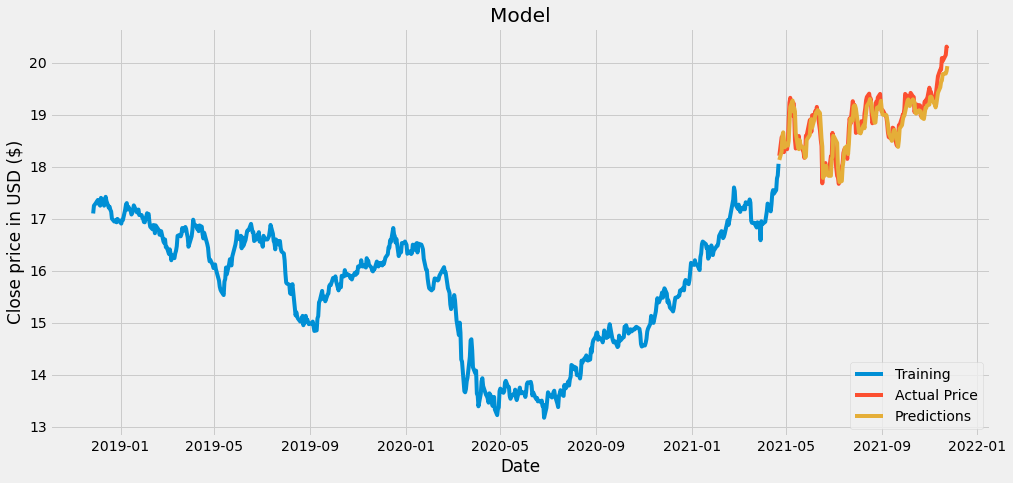

In [383]:
# Plot the data
train= data[: training_data_length]
valid= data[training_data_length:]
valid["Predictions"]= predictions

plt.figure(figsize=(15,7))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Close price in USD ($)")
plt.plot(train["close"])
plt.plot(valid[["close", "Predictions"]])
plt.legend(["Training", "Actual Price", "Predictions"], loc="lower right")
plt.show()